In [15]:
import time
import copy
import PIL.Image as Image
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision.transforms as tf
from torch.utils import data 
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [16]:
class MinMaxNormalization(object):
    """
    Normalized (Min-Max) the image.
    """
    def __init__(self, vmin=0, vmax=1):
        """
        Constructor of the grayscale transform.
        ----------
        INPUT
            |---- vmin (float / int) the desired minimum value.
            |---- vmax (float / int) the desired maximum value.
        OUTPUT
            |---- None
        """
        self.vmin = vmin
        self.vmax = vmax

    def __call__(self, image, mask=None):
        """
        Apply a Min-Max Normalization to the image.
        ----------
        INPUT
            |---- image (PIL.Image) the image to normalize.
        OUTPUT
            |---- image (np.array) the normalized image.
        """
        arr = np.array(image).astype('float32')
        arr = (arr - arr.min()) / (arr.max() - arr.min())
        arr = (self.vmax - self.vmin) * arr + self.vmin
        return arr

class Cuttings_Dataset(data.Dataset):
    def __init__(self, sample_df, data_path, mean, std, resize,data_augmentation=True):
        """
        Constructor of the dataset.
        """
        data.Dataset.__init__(self)
        self.sample_df = sample_df
        self.data_path = data_path
        self.data_augmentation = data_augmentation
        
        self.transform =  tf.Compose([tf.Grayscale(num_output_channels=3),
                                        MinMaxNormalization(),
                                        tf.ToTensor(),
                                        tf.Normalize((mean,mean,mean),(std,std,std))])
        
        if data_augmentation:
            self.transform = tf.Compose([tf.Grayscale(num_output_channels=3),
                                            tf.RandomVerticalFlip(p=0.5),
                                            tf.RandomHorizontalFlip(p=0.5),
                                            tf.RandomRotation([-90,90],resample=False, expand=False, center=None, fill=None),
                                            MinMaxNormalization(),
                                            tf.ToTensor(),
                                            tf.Normalize((mean,mean,mean),(std,std,std))])
        
        if resize:
            self.transform = tf.Compose([tf.Grayscale(num_output_channels=3),
                                            tf.Resize(224),
                                            tf.RandomVerticalFlip(p=0.5),
                                            tf.RandomHorizontalFlip(p=0.5),
                                            tf.RandomRotation([-90,90],resample=False, expand=False, center=None, fill=None),
                                            MinMaxNormalization(),
                                            tf.ToTensor(),
                                            tf.Normalize((mean,mean,mean),(std,std,std))])
    def __len__(self):
        """
        Get the number of samples in the dataset.
        """
        return self.sample_df.shape[0]


    def __getitem__(self, idx):
        """
        Get an item from the dataset.
        """
        # load image
        im = Image.open(self.data_path + self.sample_df.loc[idx,'path'])
        # load label
        label = torch.tensor(self.sample_df.loc[idx,'rock_type'])
        
        im = self.transform(im)
        return im,label

In [25]:
# Load model
PATH_to_repo =  "C:/Users/nilso/Documents/EPFL/MA4/PDS Turberg/"
PATH = PATH_to_repo + "Rock_Cuttings_Characterisation/Models/Results/model_10/model_3"

model = torch.load(PATH)

newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))

In [30]:
# Load data
df_path = pd.read_csv('../Data/test/csv_resized_128/test_resized_128.csv', index_col = 0)

# Create dataset
dataset = Cuttings_Dataset(sample_df=df_path,
                        data_path= PATH_to_repo + 'Rock_Cuttings_Characterisation/Data', 
                        mean = 0.5157003,
                        std = 0.32948261, 
                        resize = True,
                        data_augmentation=False)

In [31]:
# Put model to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

preds_vec = []
for i in range(dataset.__len__()):
    inputs, _ = dataset.__getitem__(i)
        
    outputs = newmodel(inputs.view(1,3,224,224).to(device))
    
    preds_vec.append(outputs.view(512).cpu().detach().numpy())

In [34]:
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(np.asarray(preds_vec))

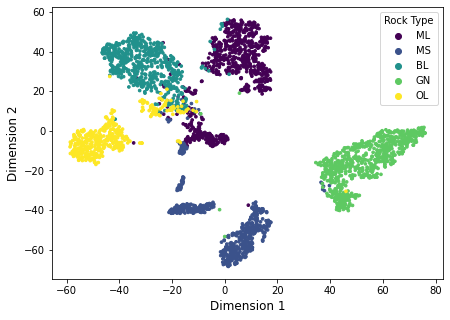

In [36]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = ax.scatter(tsne_data[:,0],tsne_data[:,1],c=df_path['rock_type'],s=7)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Rock Type",fontsize=10)
legend1.get_texts()[0].set_text('ML')
legend1.get_texts()[1].set_text('MS')
legend1.get_texts()[2].set_text('BL')
legend1.get_texts()[3].set_text('GN')
legend1.get_texts()[4].set_text('OL')
plt.setp(legend1.get_title(),fontsize=10)
plt.xlabel('Dimension 1',fontsize=12)
plt.ylabel('Dimension 2',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('tsne.png',bbox_inches='tight')